# Introduction

**Football Player role classification with CNN`s**<br>
using movement heatmap

# Loading dataset

In [ ]:
!pip install gdown

In [ ]:
import gdown
import zipfile

file_id = '1D_Uesj--6NaeZ02M-FBlC1RwtiV-fe4k'
destination = '/content/HeatMap_Data.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}',
               destination,
               quiet=True)

with zipfile.ZipFile(destination, 'r') as zip_ref:
     zip_ref.extractall('HeatMap_Data')

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading and Preprocessing

> Since the images are rectangular due to the shape of a football field, I used padding with a background color to ensure that no details are lost when resizing the images.

In [ ]:
import os
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from torchvision.transforms import functional as F


class ResizeWithPadding(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image):
        width, height = image.size
        target_width, target_height = self.size

        scale = min(target_width / width, target_height / height)

        new_width = int(width * scale)
        new_height = int(height * scale)
        image = F.resize(image, (new_height, new_width))

        padding_left = (target_width - new_width) // 2
        padding_top = (target_height - new_height) // 2
        padding_right = target_width - new_width - padding_left
        padding_bottom = target_height - new_height - padding_top

        top_left_pixel = image.getpixel((0, 0))

        image = F.pad(image, (padding_left, padding_top, padding_right, padding_bottom), fill=top_left_pixel)

        return image


class HeatmapDataset(Dataset):
    def __init__(self, data_dir, transform=None, test=False):
        self.data_dir = data_dir
        self.transform = transform
        self.test = test
        self.images = sorted(os.listdir(data_dir)) if test else []
        self.labels = []
        self.class_names = ["Defender", "Forward", "Goalkeeper","Midfielder"]

        if not test:
            class_names = sorted(os.listdir(data_dir))
            for class_index, class_name in enumerate(class_names):
                class_dir = os.path.join(data_dir, class_name)
                for image_name in os.listdir(class_dir):
                    self.images.append(os.path.join(class_dir, image_name))
                    self.labels.append(class_index)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.images[idx])
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.test:
            return image, self.images[idx]
        else:
            return image, self.labels[idx]

transform = transforms.Compose([
    ResizeWithPadding((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    ResizeWithPadding((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
data_dir = "/content/HeatMap_Data/train"

dataset = HeatmapDataset(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Designing Model Architecture

In [ ]:
import torch
import torch.nn as nn

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

## Loss function and Optimizer

In [ ]:
import torch.optim as optim

model = AdvancedCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

## Evaluator

In [ ]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

## Trainer

In [ ]:
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                epochs=20,
                patience=5):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        print(f"Epoch {epoch+1},\
         Train Loss: {running_loss/len(train_loader):.4f},\
          Train Acc: {train_accuracy:.2f}%,\
           Val Loss: {val_loss:.4f},\
            Val Acc: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

# Trainning

In [ ]:
train_model(model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            20,
            5)

Epoch 1,         Train Loss: 1.3678,          Train Acc: 26.50%,           Val Loss: 1.2422,            Val Acc: 47.50%
Epoch 2,         Train Loss: 0.8848,          Train Acc: 60.25%,           Val Loss: 0.4207,            Val Acc: 87.50%
Epoch 3,         Train Loss: 0.2602,          Train Acc: 89.27%,           Val Loss: 0.3687,            Val Acc: 92.50%
Epoch 4,         Train Loss: 0.2223,          Train Acc: 92.74%,           Val Loss: 0.1922,            Val Acc: 93.75%
Epoch 5,         Train Loss: 0.2103,          Train Acc: 94.01%,           Val Loss: 0.4228,            Val Acc: 88.75%
Epoch 6,         Train Loss: 0.1538,          Train Acc: 93.69%,           Val Loss: 0.2764,            Val Acc: 88.75%
Epoch 7,         Train Loss: 0.1582,          Train Acc: 94.64%,           Val Loss: 0.2724,            Val Acc: 92.50%
Epoch 8,         Train Loss: 0.1420,          Train Acc: 95.90%,           Val Loss: 0.2393,            Val Acc: 91.25%
Epoch 9,         Train Loss: 0.0886,    

# Prediction

> Loading test dataset

In [ ]:
test_data_dir = "/content/HeatMap_Data/test"

test_dataset = HeatmapDataset(test_data_dir, transform=test_transform, test=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

> define test function

In [ ]:
import pandas as pd

def predict_and_save_submission(model, test_loader, output_file="submission.csv"):
    predictions = []
    class_names = test_loader.dataset.class_names

    with torch.no_grad():
        for images, image_names in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_class = class_names[predicted.item()]
            predictions.append((image_names[0], predicted_class))

    predictions.sort(key=lambda x: int(x[0].split('.')[0]))

    df = pd.DataFrame(predictions, columns=["Image", "Position"])
    df.drop(columns=["Image"], inplace=True)
    df.to_csv(output_file, index=False)
    print(f"Submission file saved as {output_file}")

> switching model to evaluate mode

In [ ]:
model.eval()

AdvancedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
)

> predicting

In [ ]:
predict_and_save_submission(model, test_loader)

Submission file saved as submission.csv


> saving model

In [ ]:
torch.save(model.state_dict(), "model.pth")

# Evaluation

> Load weights

In [ ]:
model.load_state_dict(torch.load("model.pth"))

<ipython-input-9-88f269442855>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

> test and show result

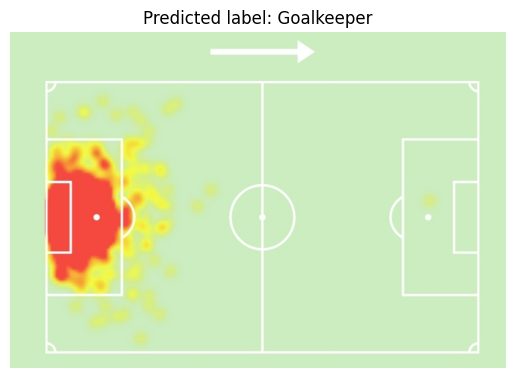

In [ ]:
import matplotlib.pyplot as plt


predictions = pd.read_csv('submission.csv')
image = np.array(Image.open('HeatMap_Data/test/0.jpg').convert('RGB'))
predicted = predictions.iloc[0, 0]

image_array = np.array(image)
plt.imshow(image_array)
plt.title(f"Predicted label: {predicted}")
plt.axis('off')
plt.show()